
# YOLOv8 Binary Object Detection and Cropping Pipeline

This notebook includes:

1. Converting YOLO dataset annotations from multi-class to binary.
2. Fine-tuning YOLOv8 for binary detection.
3. Inference pipeline (detection -> cropping -> augmentation -> classification preparation).

Abdulmlik almuhanna

In [2]:

!pip install -q ultralytics roboflow sahi keras

!pip install -q glob2
import os
from sahi.utils.file import download_from_url
from sahi.utils.ultralytics import download_yolo11n_model
from ultralytics import YOLO
from roboflow import Roboflow
import cv2
import numpy as np
from glob import glob


/hpc/home/ama191/miniconda3/envs/test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-17 12:01:39.235018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752768100.519166  492591 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752768100.997892  492591 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752768104.316219  492591 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more t

In [ ]:

#from roboflow import Roboflow
#rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
#project = rf.workspace("insectai").project("insects_noclasses")
#version = project.version(7)
#dataset = version.download("yolov8")
rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
project = rf.workspace("insectai").project("segtoboxes_noclass")
version = project.version(3)
dataset = version.download("yolov8")
                
                
                
                
                
# the SF sliced dataset:
# this is done after running the Sahi slicing script below but i uploaded the sliced images to Roboflow
# to make it easier to download the dataset and change the annotations to YOLO format
rf = Roboflow(api_key="TS1niacLXvvWTierCKCT")
project = rf.workspace("insectai").project("experiment-pzbwo")
version = project.version(4)
dataset = version.download("yolov8")
                
                
                

                


loading Roboflow workspace...
loading Roboflow project...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to experiment--4 in yolov8:: 100%|██████████| 1194/1194 [00:13<00:00, 86.91it/s] 


Sahi slicers

In [ ]:
# this code is used to slice the dataset into smaller images using Sahi i would recommend running this on GPU
# this technique is used to slice large images into smaller ones to make it easier for the model to detect objects
import sahi
from sahi.slicing import slice_coco ,get_auto_slice_params
 
coco_json = "/hpc/home/ama191/Our_Yolo_Solution/segToBoxes_NoClass-3/train/_annotations.coco.json"
output_dir = "dataset_sliced_3"
image_dir = "/hpc/home/ama191/Our_Yolo_Solution/segToBoxes_NoClass-3/train/"
x=get_auto_slice_params(1504,1504)
print(x)
#Slice training set
slice_coco(
    coco_annotation_file_path=coco_json,
    image_dir=image_dir,
    output_coco_annotation_file_name=os.path.join(output_dir, "train_coco_sliced.json"),
    output_dir=output_dir,
    slice_height=752,
    slice_width=752,
    overlap_height_ratio=0.3,
    overlap_width_ratio=0.3
)

SyntaxError: invalid syntax (831812005.py, line 5)

### training the binary detector

In [ ]:
# this code is for downloading the YOLOx11-p2 with pretrained weights on coco dataset  from Hugging Face

#!git clone https://huggingface.co/davsolai/yolo11x-p2-coco
#!cd yolo11x-p2-coco && git fetch origin refs/pr/1:pr/1

Cloning into 'yolo11x-p2-coco'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (11/11), 3.62 KiB | 24.00 KiB/s, done.


In [9]:
import yaml

# Define hyperparameters for the detector model
hyperparams = { # Replace this dynamically if needed
    'epochs': 200,
    'imgsz': 1504,
    'batch': 2,
    'project': 'binary_detector',
    'max_det': 600,
    'single_cls':True,
    'visualize':True,
    'save_crop':True,
    'show_labels':False,
    'warmup_epochs':20.0,
}

# Save the hyperparameters to a YAML file
with open("cgs.yaml", "w") as file:
  yaml.dump(hyperparams, file)
print("Hyperparameters saved to 'cgs.yaml'.")

Hyperparameters saved to 'cgs.yaml'.


In [ ]:

# Fine-tune YOLO on binary dataset
model = YOLO("/hpc/home/ama191/Our_Yolo_Solution/yolo11x-p2-coco/model (1).pt")

In [ ]:
model.train(data="/hpc/home/ama191/Our_Yolo_Solution/segToBoxes_NoClass-1/data.yaml",cfg="./cgs.yaml")

New https://pypi.org/project/ultralytics/8.3.167 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.7.0+cu126 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=./cgs.yaml, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/hpc/home/ama191/Our_Yolo_Solution/segToBoxes_NoClass-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=200, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1504, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=600, mixup=0.0, mode=train, model=/hpc/home/ama191/Our_Yolo_Solution/yolo11x-p2-coco/model (1).p

train: Scanning /hpc/home/ama191/Our_Yolo_Solution/segToBoxes_NoClass-1/train/labels.cache... 660 images, 0 backgrounds, 0 corrupt: 100%|██████████| 660/660 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 33048, len(boxes) = 42808. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


val: Fast image access ✅ (ping: 0.7±0.1 ms, read: 8.5±3.1 MB/s, size: 208.9 KB)


val: Scanning /hpc/home/ama191/Our_Yolo_Solution/segToBoxes_NoClass-1/valid/labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]


Plotting labels to binary_detector/train39/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 206 weight(decay=0.0), 215 weight(decay=0.0005), 214 bias(decay=0.0)
Image sizes 1504 train, 1504 val
Using 8 dataloader workers
Logging results to binary_detector/train39
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      13.9G      1.962      5.582       2.19         37       1504:   0%|          | 1/330 [00:07<42:41,  7.78s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      15.5G      2.083      5.954      2.257         20       1504:   1%|          | 3/330 [00:13<21:26,  3.94s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      3.21G      2.139      5.504      2.285        335       1504:   1%|          | 4/330 [00:19<24:58,  4.60s/it]

WARNING ⚠️ CUDA OutOfMemoryError in TaskAlignedAssigner, using CPU


      1/200      3.21G      2.139      5.504      2.285        335       1504:   1%|          | 4/330 [00:21<28:38,  5.27s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 92.00 MiB. GPU 0 has a total capacity of 15.89 GiB of which 71.12 MiB is free. Including non-PyTorch memory, this process has 15.81 GiB memory in use. Of the allocated memory 15.33 GiB is allocated by PyTorch, and 138.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
model.val(save=True)

NameError: name 'model' is not defined

### SAHI experiment 

In [78]:
# i have the model pre trained
model_path="/hpc/home/ama191/Our_Yolo_Solution/binary_detector/train38-SF/weights/best.pt"
model = YOLO("/hpc/home/ama191/Our_Yolo_Solution/binary_detector/train38-SF/weights/best.pt")
#model.predict(source="/content/insects_noclasses-7/test/images/test_img_cropped.JPG",save=True,iou=0.5)

Standard Predection without SAHI

In [7]:
from sahi import AutoDetectionModel

detection_model = AutoDetectionModel.from_pretrained(
    model_type="ultralytics",
    model_path=model_path,
    confidence_threshold=0.2,
    device="cuda:0",
    )

In [50]:
from sahi.predict import get_sliced_prediction
org_img="/hpc/home/ama191/Our_Yolo_Solution/insects_noclasses-10/valid/images/W5_20230821_3_ST230743_A_JPG.rf.4717bce65610ce1b519201087013d9df.jpg"

result = get_sliced_prediction(
    org_img,
    detection_model,
    slice_height=752,
    slice_width=752,
    overlap_height_ratio=0.3,
    overlap_width_ratio=0.3,
    postprocess_type="GREEDYNMM"
)


Performing prediction on 9 slices.


In [51]:
len(result.object_prediction_list)


22

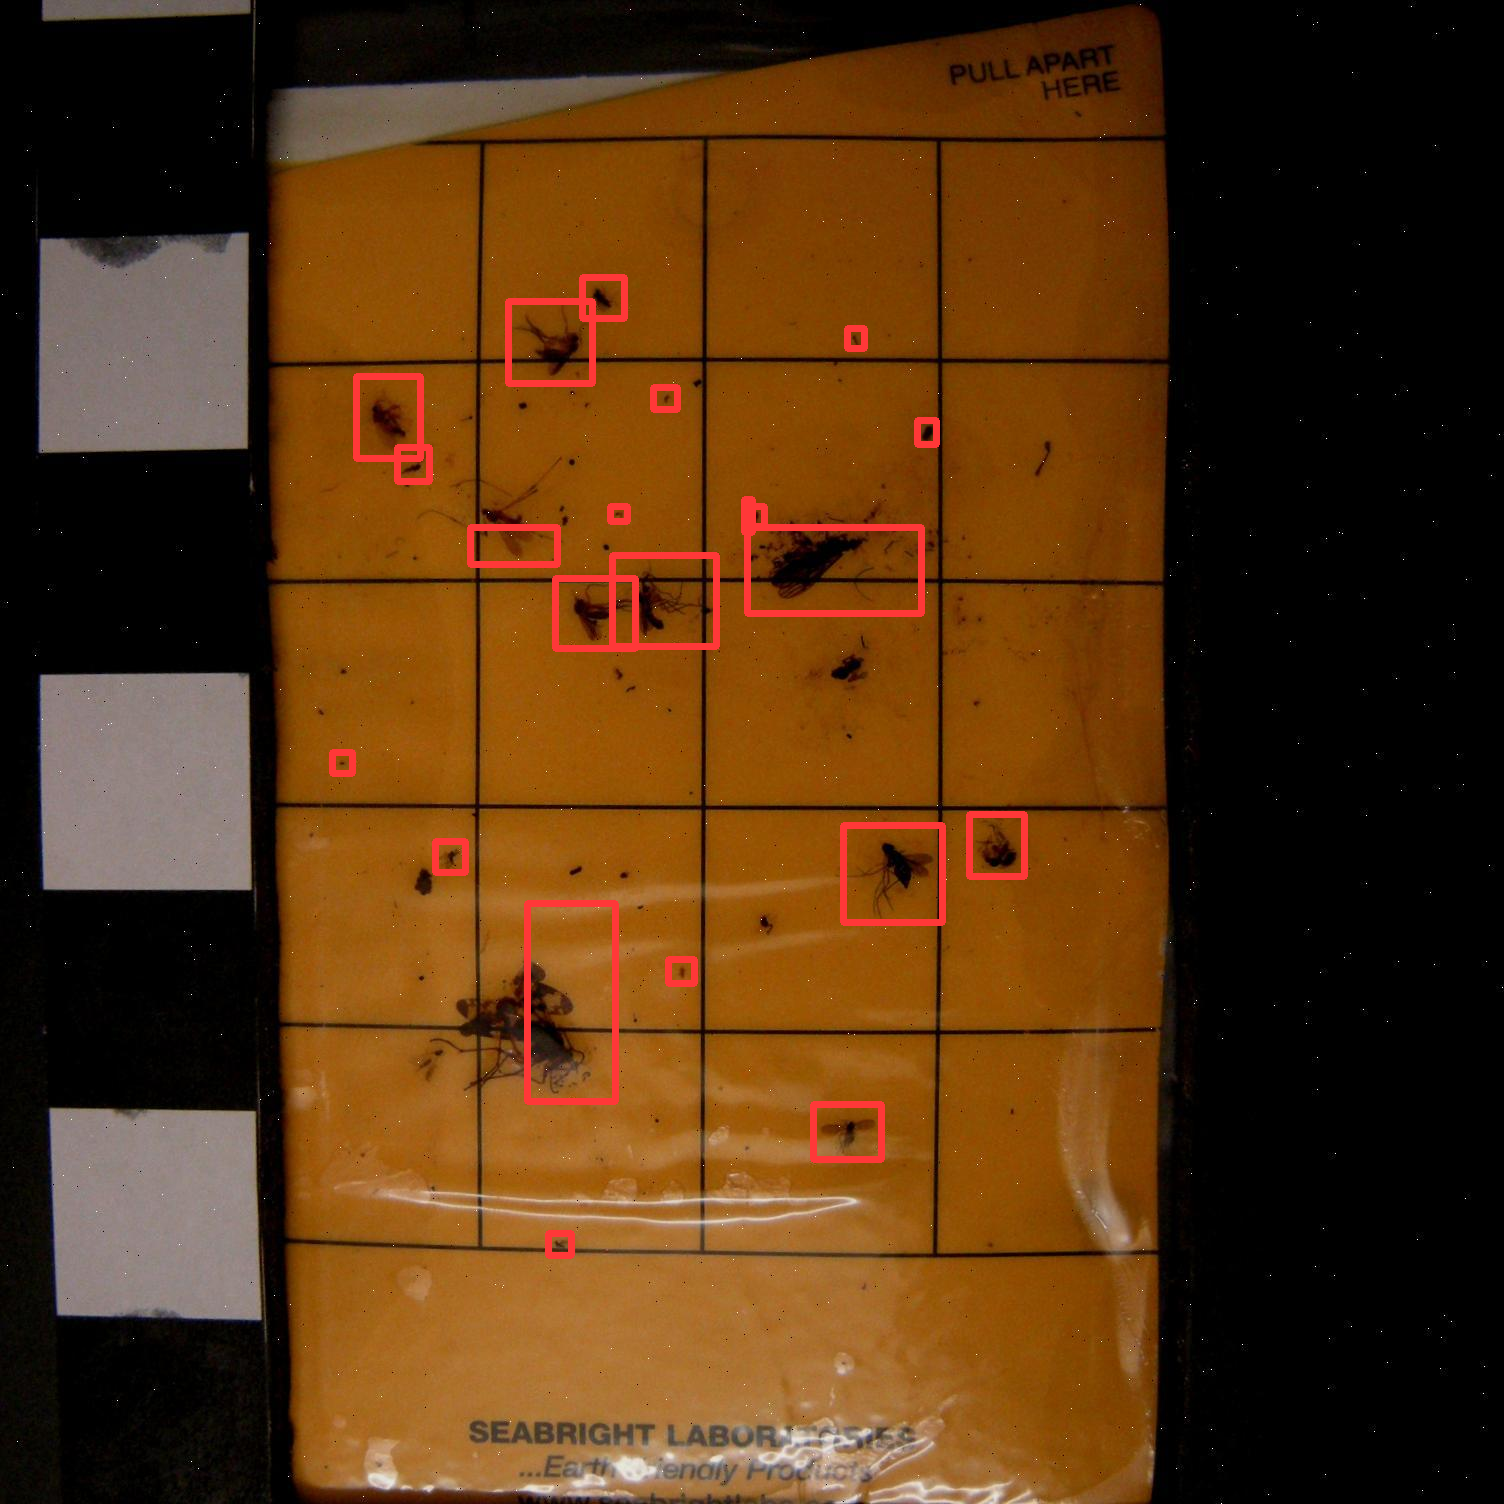

In [52]:
from IPython.display import Image
result.export_visuals(export_dir="real_sihi/",hide_labels=True)
result.object_prediction_list
Image("real_sihi/prediction_visual.png")


### Cropping part

In [67]:

import cv2

def crop_predictions_from_sahi(image_path, sahi_result, conf_thresh=0.01):
    """
    Crops objects from the image based on SAHI prediction result.

    Args:
        image_path (str): Path to the image.
        sahi_result (sahi.prediction.PredictionResult): The SAHI prediction result object.
        conf_thresh (float): Confidence threshold to filter predictions.

    Returns:
        List of cropped image regions (NumPy arrays).
    """
    img = cv2.imread(image_path)
    crops = []

    for obj in sahi_result.object_prediction_list:
        if obj.score.value < conf_thresh:
            continue
        x1, y1, x2, y2 = map(int, obj.bbox.to_xyxy())
        crop = img[y1:y2, x1:x2]
        crops.append(crop)

    return crops
import cv2
import os

def save_crops(crops, save_dir, base_filename="crop"):
    """
    Saves cropped images to a specified directory.

    Args:
        crops (List[np.array]): List of cropped image arrays.
        save_dir (str): Directory to save the crops.
        base_filename (str): Base name for saved files.
    """
    os.makedirs(save_dir, exist_ok=True)

    for idx, crop in enumerate(crops):
        save_path = os.path.join(save_dir, f"{base_filename}_{idx + 1}.jpg")
        cv2.imwrite(save_path, crop)
    print(f"images saved!")


In [66]:
from glob import glob
import glob2

import matplotlib.pyplot as plt
import os
crops = crop_predictions_from_sahi(org_img, result, conf_thresh=0.05)
folder = '/hpc/home/ama191/Our_Yolo_Solution/cropped_results'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
save_crops(crops, save_dir="cropped_results", base_filename="insect")




images saved!


plot crops

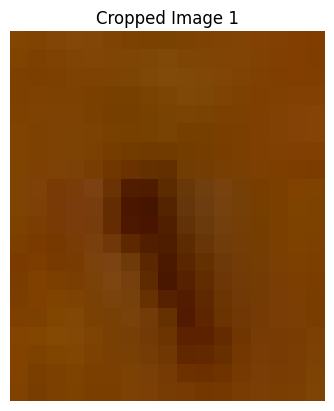

In [68]:

plt.figure()
plt.imshow(cv2.cvtColor(crops[15], cv2.COLOR_BGR2RGB))
plt.title(f"Cropped Image {1}")
plt.axis('off')
plt.show()

# Pipeline Inferance YOLO & ResNet Models

inference ResNet


In [74]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import os
import matplotlib.pyplot as plt
import keras
import tensorflow
cls_model_path="/hpc/home/ama191/Our_Yolo_Solution/best_model.keras"
# 🔄 Load Model
#model = models.resnet18(pretrained=False)
model = keras.saving.load_model(cls_model_path, custom_objects=None, compile=True, safe_mode=True)
model_2 = keras.saving.load_model("/hpc/home/ama191/Our_Yolo_Solution/clsModels/best_model_.89.h5", custom_objects=None, compile=True, safe_mode=True)
model_3 = keras.saving.load_model("/hpc/home/ama191/Our_Yolo_Solution/clsModels/best_model.h5", custom_objects=None, compile=True, safe_mode=True)

07/15/2025 21:20:47 - WARNING - absl -   Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
07/15/2025 21:20:49 - WARNING - absl -   Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


In [76]:
import os
from keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import shutil
# Initialize counter before the loop
class_counts = defaultdict(int)

# Paths
image_dir = "/hpc/home/ama191/Our_Yolo_Solution/cropped_results/"

folder = '/hpc/home/ama191/Our_Yolo_Solution/results2'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

Failed to delete /hpc/home/ama191/Our_Yolo_Solution/results2/.nfs0000000ed5005bd1000000bd. Reason: [Errno 16] Device or resource busy: '/hpc/home/ama191/Our_Yolo_Solution/results2/.nfs0000000ed5005bd1000000bd'


In [77]:

output_dir = "results2/"
os.makedirs(output_dir, exist_ok=True)

# Class labels (customize these to match your model)
class_names = ['0', '1', '2','3','4','5']

# Image size (must match model input)
img_size = (224, 224)

# Loop through images
for file_name in os.listdir(image_dir):
    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(image_dir, file_name)
    img = load_img(img_path, target_size=img_size)
    img_array = img_to_array(img)
    img_batch = np.expand_dims(img_array / 255.0, axis=0)  # normalize

    # Predict
    preds = model_2.predict(img_batch)
    pred_index = np.argmax(preds)
    pred_class = class_names[pred_index]
    class_counts[pred_class] += 1
    confidence = preds[0][pred_index]

    # Plot and save
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class} ({confidence:.2f})")
    plt.axis('off')
    save_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}_pred.png")
    plt.savefig(save_path)
    plt.close()

    print(f"{file_name} → {pred_class} ({confidence:.2f})")
print("\nClass Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} times")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
insect_20.jpg → 3 (0.86)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
insect_7.jpg → 3 (0.96)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
insect_10.jpg → 3 (0.90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
insect_17.jpg → 3 (0.94)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
insect_16.jpg → 3 (0.75)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
insect_11.jpg → 3 (0.91)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
insect_9.jpg → 3 (0.66)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
insect_15.jpg → 3 (0.71)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
insect_5.jpg → 3 (0.93)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
insect_21.jpg → 1 (0.42)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
insect_8.jpg → 3 (0.51)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
insect_19.jpg → 3 (0.92)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
insect_18.jpg → 3 (0.59)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
insect_14.jpg → 3 (0.80)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
insect_22.jpg → 3 (0.90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
insect_12.jpg → 3 (0.90

In [49]:
org_img

'/hpc/home/ama191/Our_Yolo_Solution/insects_noclasses-10/valid/images/W5_20220509_5_ST220185_A_JPG.rf.4ad9132b6f5da90c7d75591084cfb668.jpg'